In [0]:
# !pip install soundfile
import os
from scipy.io import wavfile
import numpy as np
import scipy
import scipy.signal
import soundfile as sf
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import csv
from collections import namedtuple
import datetime
import time
from google.colab import drive
import h5py
import cv2
from PIL import Image, ImageOps

# Connect to google drive



In [3]:
drive.mount('/content/drive')
os.chdir('/content/drive/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Get the labels <br>
Low and highFrequencies are in col 5 and 6. <br>
File path is in col 7. <br>
Begin clock time is in col 10. <br>
Use the start and end clock time (in col 3,4) adding to the begin clock time to decide the time period. <br>
Sonotype is in col 11.

Q: Selection 269, 377, 1157, 1428, sonotype is alphabet? <br>

269	Spectrogram 1	1	153655.481400000	153697.202500000	530.949	991.625	C:\Users\Tatiana\Documents\Sound Forest Lab\taxon_group_recordings\13A\13A_audios\20180809_180000_13A_24H [1.4452 116.9811].wav	2018/8/9	41.7211	18:18:00.4814	A	-	0


In [4]:
labelFile = "Shared drives/Stethoscope for the rainforests/Training data set /Table_13A_10.txt"

times = [] 
freqs = []
files = []
sonotypes = []

with open(labelFile) as file:
  label_reader = csv.reader(file, delimiter='\t')
  for row in label_reader:
      # not use the first row
      if (not row[0].isnumeric()):
        continue

      # all the recording are either start at 0min or 30mins
      timeWeight = [60,1,0.1]
      start = sum([a*b for a,b in zip(timeWeight, map(int,row[10].replace('.',":").split(':')))]) % 1800
      end = start + float(row[4]) - float(row[3])

      try:
        sonotypes.append(int(row[11]))
        times.append([start,end])
        freqs.append([float(row[5]), float(row[6])])
        files.append(row[7].split("\\")[-1]) 
      except:
        # selection number
        print(row[0])
        pass

print("dataset size:  %i" % len(times))    
print("filename sample: " + files[0])

269
377
1157
1428
dataset size:  1233
filename sample: 3B_20180607_070500_Dawn_Sunrise_Based.wav


# Get the data according to the labels.

In [5]:
# all the sound files
fileDir = "Shared drives/Stethoscope for the rainforests/Sound data/EastKalimantan/13A/"
soundFiles = os.listdir(fileDir)
usedFiles = np.intersect1d(soundFiles, files)

# get spectrogram data
specs = [None] * len(times) #list storing spectrogram data

for curFile in usedFiles:
  print("processing " + curFile)
  filePath = fileDir + curFile
  audio, rate = sf.read(filePath)

  # plot the spectrogram
  freq, t, spec = scipy.signal.spectrogram(audio, rate)
  for i in range(len(files)):
    if(files[i] == curFile):
      boxTime = times[i]
      boxFreq = freqs[i]

      # get low and high freq index of the box
      low_freq = np.argmin(np.abs(freq - boxFreq[0]))
      high_freq = np.argmin(np.abs(freq - boxFreq[1]))
      # get start and end time of the box
      start = np.argmin(np.abs(t - boxTime[0]))
      end = np.argmin(np.abs(t - boxTime[1]))

      # adjust the params to cover the whole box
      if freq[low_freq] > boxFreq[0]: 
        low_freq = low_freq -1

      if freq[high_freq] < boxFreq[1]: 
        high_freq = high_freq + 1

      if t[start] > boxTime[0]: 
        start = start - 1

      if t[end] < boxTime[1]: 
        start = start + 1

      specs[i] = spec[low_freq:high_freq, start:end]
      # boxFreqPlt = freq[low_freq: high_freq]
      # boxTPlt = t[start:end]


processing 20180710_060000_13A_24H [1.4452 116.9811].wav
processing 20180710_180000_13A_24H [1.4452 116.9811].wav
processing 20180809_060000_13A_24H [1.4452 116.9811].wav
processing 20180809_180000_13A_24H [1.4452 116.9811].wav
processing 20180908_060000_13A_24H [1.4452 116.9811].wav
processing 20180908_180000_13A_24H [1.4452 116.9811].wav
processing 20181008_060000_13A_24H [1.4452 116.9811].wav
processing 20181008_173000_13A_24H [1.4452 116.9811].wav
processing 20181107_060000_13A_24H [1.4452 116.9811].wav
processing 20181107_173000_13A_24H [1.4452 116.9811].wav
processing 20181207_060000_13A_24H [1.4452 116.9811].wav
processing 20181207_173000_13A_24H [1.4452 116.9811].wav
processing 20190106_060000_13A_24H [1.4452 116.9811].wav
processing 20190106_180000_13A_24H [1.4452 116.9811].wav
processing 20190205_063000_13A_24H [1.4438 116.9805].wav
processing 20190205_180000_13A_24H [1.4438 116.9805].wav
processing 20190307_060000_13A_24H [1.4438 116.9805].wav
processing 20190307_180000_13A_

# Resize the data

In [21]:
specs_resized = []

for spec in specs:
  spec_resized=cv2.resize(spec,(224,224))
  spec_resized=cv2.cvtColor(spec_resized.astype('float32'), cv2.COLOR_BGR2RGB) #cv2 does not accept float64
  specs_resized.append(np.array(spec_resized).reshape((3,224,224)))
  
print(specs_resized[0].shape)

(3, 224, 224)
1233


# Store data to H5 data storage 

In [27]:
with h5py.File('My Drive/Stethoscope/13A_data.hdf5', 'w') as f:
  for i in range(len(specs_resized)):
    # f.create_dataset(sonotypes[i], data=np.array(specs[i], dtype= np.float64))
    data = f.create_dataset(str(sonotypes[i]), np.aay(specs_resized[i].flatten()))

ValueError: ignored

Classifies the datas based on sonotypes <br>
There are 251 sonotypes currently. <br>

Stored in the dictionary with key = sonotype and value = [spec1, spec2,....]

Q: max sonotype is 470, but only 251 unique sonotypes in all labels, missing?

# **Misc**

## tests and others

In [25]:
# number_type = np.max(sonotypes)
# print(number_type)

data = {}
for i in range(len(specs_resized)):
  if sonotypes[i] in data:
    data[sonotypes[i]].append(specs_resized[i])
  else:
    data[sonotypes[i]] = [specs_resized[i]]

print("dictionary size: %i" % len(data))  

dictionary size: 251


Resize spectrograms to 224 * 224 * 3, test whether look the same to the original spectrogram.

spec number: 615
(224, 224, 3)


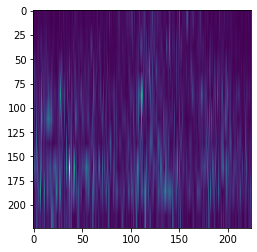

In [93]:
index = random.randint(0, len(freqs) - 1)
print("spec number: %d" % index)

# file=cv2.cvtColor(specs[index].astype('uint8'), cv2.COLOR_BGR2RGB)
file=cv2.cvtColor(specs[index].astype('float32'), cv2.COLOR_BGR2RGB)

file=cv2.resize(file,(224,224))

print(file.shape)
plt.imshow(file[:,:,1])
plt.show()

spec number: 615


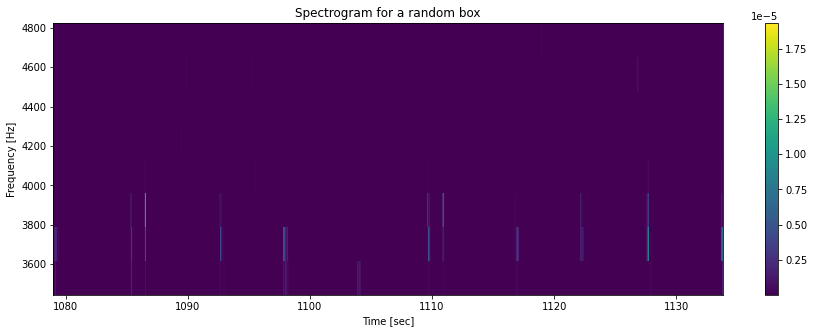

In [94]:
# compute the data for the spectrogram
print("spec number: %d" % index)
ranFile = files[index]
fileDir = "Shared drives/Stethoscope for the rainforests/Sound data/EastKalimantan/13A/"
ranFilePath = fileDir + curFile
audio, rate = sf.read(ranFilePath)
freq, t, spec = scipy.signal.spectrogram(audio, rate)

# get low and high freq index of the box
boxTime = times[index]
boxFreq = freqs[index]

# get low and high freq index of the box
low_freq = np.argmin(np.abs(freq - boxFreq[0]))
high_freq = np.argmin(np.abs(freq - boxFreq[1]))
# get start and end time of the box
start = np.argmin(np.abs(t - boxTime[0]))
end = np.argmin(np.abs(t - boxTime[1]))

# adjust the params to cover the whole box
if freq[low_freq] > boxFreq[0]: 
  low_freq = low_freq -1

if freq[high_freq] < boxFreq[1]: 
  high_freq = high_freq + 1

if t[start] > boxTime[0]: 
  start = start - 1

if t[end] < boxTime[1]: 
  start = start + 1

boxSpecPlt = spec[low_freq:high_freq, start:end]
boxFreqPlt = freq[low_freq: high_freq]
boxTPlt = t[start:end]

# plot the spectrogram
# set up
plt.figure(figsize=(15, 5))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title("Spectrogram for a random box")

# plot
plt.pcolormesh(boxTPlt, boxFreqPlt, boxSpecPlt)
plt.colorbar()

Test whether the boxes are interpreted correctly

In [0]:
pltFile = usedFiles[0]
filePath = fileDir + pltFile
audio, rate = sf.read(filePath)

# set up
plt.figure(figsize=(30, 10))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title("Spectrogram of the wav file: " + pltFile)

# plot spectrogram
freq, t, spec = scipy.signal.spectrogram(audio, rate)
plt.pcolormesh(t, freq, spec)
# plt.pcolormesh(wholeT, wholeFreq, wholeSpec)

# Create Rectangle patches
for i in range(len(times)):
   if(files[i] == pltFile):
      boxTime = times[i]
      boxFreq = freqs[i]

      # get low and high freq index of the box
      low_freq = np.argmin(np.abs(freq - boxFreq[0]))
      high_freq = np.argmin(np.abs(freq - boxFreq[1]))
      # get start and end time of the box
      start = np.argmin(np.abs(t - boxTime[0]))
      end = np.argmin(np.abs(t - boxTime[1]))

      # adjust the params to cover the whole box
      if freq[low_freq] > boxFreq[0]: 
        low_freq = low_freq -1

      if freq[high_freq] < boxFreq[1]: 
        high_freq = high_freq + 1

      if t[start] > boxTime[0]: 
        start = start - 1

      if t[end] < boxTime[1]: 
        start = start + 1
          
      ymin = freq[low_freq]/freq[len(freq) -1]
      ymax = freq[high_freq]/freq[len(freq) -1]
      xmin = t[start]
      xmax = t[end]
      plt.axvspan(xmin, xmax, ymin=ymin, ymax=ymax, fill = False)